# 1. Import libraries and datasets

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import sys
import string
import nltk
import matplotlib.pyplot as plt
from time import time
from nltk.corpus import stopwords
from sklearn.cluster import MiniBatchKMeans, KMeans
from scipy.spatial.distance import cdist
import pickle

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim') #ignoring the gensim warning related to the OS

from gensim.models import Word2Vec

From within a python file, you can add pathto the default path by adding the following lines. Now the pmi_utils is added to the library path

In [2]:
sys.path.insert(0, 'pmi_utils')

Now is possible to import the shared_variable library, containing all the variables used

In [3]:
import shared_variables
from shared_variables import *

Reload the library, in order to reflect updates on it

In [4]:
shared_variables = reload(shared_variables)

In case of sample data, read it. Otherwise, starting from the zipped DBLP XML file, extract it, serialize it in json format and take a sample of that data.
Once the sample is created serialize it in json file.

In [5]:
def load_json_dblp():
    #Read the JSON file containing all the DBLP records
    df_json_dblp = pd.read_json(f_json_dblp)
    #Rename the dataframe columns
    df_json_dblp.columns = columns
    # Sample with fixed random state
    df_sample_dblp = df_json_dblp.sample(frac=0.1)
    # Free memory
    del df_json_dblp
    # Cache sample JSON file
    df_sample_dblp.to_json(f_sample_dblp)

try:
    #check if the file exists and can be readed
    with open(f_sample_dblp, 'r') as f:
        pass
    #read the serialized sample
    df_sample_dblp = pd.read_json(f_sample_dblp)
except:
    try:
        #check if the XML file has already been converted to JSON and can be readed
        with open(f_json_dblp, 'r') as f:
            pass
        load_json_dblp()
        #read the serialized sample
        df_sample_dblp = pd.read_json(f_sample_dblp)
    except:
        #There is no sample. Extract the Zipped DBLP XML file and serialize it in Zipped JSON
        %run pmi_utils/dblp_xml_to_json.py path_data
        #Read the zipped JSON and make it available
        %run pmi_utils/extract_zipped_json.py
        load_json_dblp()
        #read the serialized sample
        df_sample_dblp = pd.read_json(f_sample_dblp)

Show the shape of the sample datasete

In [6]:
df_sample_dblp.shape

(614193, 9)

Show the first 5 row in the dataset

In [7]:
df_sample_dblp.head()

,authors,booktitle,ee,journal,paper_id,papertype,title,url,year
1000002,"[Jamshid Abouei, J. David Brown, Konstantinos ...",None,http://arxiv.org/abs/1101.0906,CoRR,journals/corr/abs-1101-0906,article,Energy Efficiency and Reliability in Wireless ...,db/journals/corr/corr1101.html#abs-1101-0906,2011.0
1000004,"[Georgios P. Spithourakis, Steffen E. Petersen...",None,http://arxiv.org/abs/1610.06370,CoRR,journals/corr/SpithourakisPR16,article,Clinical Text Prediction with Numerically Grou...,db/journals/corr/corr1610.html#SpithourakisPR16,2016.0
1000005,"[Emmanuel Promayon, Céline Fouard, Mathieu Bai...",None,http://arxiv.org/abs/1310.5497,CoRR,journals/corr/PromayonFBDFHLPSSSVCT13,article,Using CamiTK for rapid prototyping of interact...,db/journals/corr/corr1310.html#PromayonFBDFHLP...,2013.0
1000019,"[Cewei Cui, Zhe Dang]",None,http://arxiv.org/abs/1711.08963,CoRR,journals/corr/abs-1711-08963,article,Random Words in a (Weighted) Regular Language:...,db/journals/corr/corr1711.html#abs-1711-08963,2017.0
1000024,"[Batu K. Chalise, Himal A. Suraweera, Gan Zhen...",None,http://arxiv.org/abs/1705.04014,CoRR,journals/corr/ChaliseSZK17,article,Beamforming Optimization for Full-Duplex Wirel...,db/journals/corr/corr1705.html#ChaliseSZK17,2017.0


Show the first 20 row, displaying the count of each paper id

In [8]:
df_sample_dblp.groupby(lbl_title)[lbl_paper_id].count().sort_values(ascending=False).head(20)

title
Home Page                  205037
Editorial.                    466
Preface.                      293
Introduction.                 125
Foreword.                     108
Book Reviews.                  53
Guest Editorial.               52
Book review.                   37
Front Matter.                  30
Book reviews.                  27
News.                          25
Book Review.                   21
In this issue.                 21
From the Editor.               20
Editorial Introduction.        20
Erratum.                       20
CyberEurope.                   20
Buchbesprechungen.             19
Minitrack Introduction.        18
New Products.                  16
Name: paper_id, dtype: int64

All these titles above that occur so often can safely be removed from our analysis as we don't have their text content and provide no added value. Let's explore the other ones.

In [9]:
df_sample_dblp = df_sample_dblp[df_sample_dblp[lbl_title] <> 'Home Page']
df_sample_dblp.shape

(409156, 9)

As well as the Home Page, filter out all papers with title occurring more than 3 times.

In [10]:
# Aggregate the row by title and count the occurences
df_grouped = df_sample_dblp.groupby(lbl_title)[lbl_paper_id].count()
# Filter paper titles occurring more than 3 times
df_sample_dblp = df_sample_dblp[~df_sample_dblp[lbl_title].isin(df_grouped[df_grouped >= 4].index)]
df_sample_dblp.head()

,authors,booktitle,ee,journal,paper_id,papertype,title,url,year
1000002,"[Jamshid Abouei, J. David Brown, Konstantinos ...",None,http://arxiv.org/abs/1101.0906,CoRR,journals/corr/abs-1101-0906,article,Energy Efficiency and Reliability in Wireless ...,db/journals/corr/corr1101.html#abs-1101-0906,2011.0
1000004,"[Georgios P. Spithourakis, Steffen E. Petersen...",None,http://arxiv.org/abs/1610.06370,CoRR,journals/corr/SpithourakisPR16,article,Clinical Text Prediction with Numerically Grou...,db/journals/corr/corr1610.html#SpithourakisPR16,2016.0
1000005,"[Emmanuel Promayon, Céline Fouard, Mathieu Bai...",None,http://arxiv.org/abs/1310.5497,CoRR,journals/corr/PromayonFBDFHLPSSSVCT13,article,Using CamiTK for rapid prototyping of interact...,db/journals/corr/corr1310.html#PromayonFBDFHLP...,2013.0
1000019,"[Cewei Cui, Zhe Dang]",None,http://arxiv.org/abs/1711.08963,CoRR,journals/corr/abs-1711-08963,article,Random Words in a (Weighted) Regular Language:...,db/journals/corr/corr1711.html#abs-1711-08963,2017.0
1000024,"[Batu K. Chalise, Himal A. Suraweera, Gan Zhen...",None,http://arxiv.org/abs/1705.04014,CoRR,journals/corr/ChaliseSZK17,article,Beamforming Optimization for Full-Duplex Wirel...,db/journals/corr/corr1705.html#ChaliseSZK17,2017.0


In [11]:
df_sample_dblp.shape

(407524, 9)

Let's see which are the most frequent journals in the dataset

In [12]:
df_sample_dblp.groupby(lbl_journal).size().sort_values(ascending=False).head(20)

journal
CoRR                                        15476
IEICE Transactions                           1966
Applied Mathematics and Computation          1747
IEEE Trans. Information Theory               1450
Discrete Mathematics                         1362
IEEE Trans. Signal Processing                1203
Sensors                                      1195
Neurocomputing                               1187
European Journal of Operational Research     1185
Theor. Comput. Sci.                          1181
Bioinformatics                               1125
IACR Cryptology ePrint Archive               1116
Commun. ACM                                  1072
Expert Syst. Appl.                           1051
IEEE Trans. Communications                    998
NeuroImage                                    986
Automatica                                    960
IEEE Trans. Computers                         898
Inf. Sci.                                     896
IEEE Trans. Industrial Electronics        

In [13]:
df_sample_dblp.shape

(407524, 9)

# 2. Infer topics by clustering paper titles

## Word2Vec

Let's define a function that cleans the text in input, in order to:
- manage null values
- remove punctuacion
- remove numbers
- filter single chars
- apply lowering
- removing stop words (from nltk + custom ones)

In [14]:
# Clean text function
def clean_text(text):
    def replace_punctuation(sentence):
        if(pd.isnull(sentence)):
            return ""
        punctuation = string.punctuation
        for p in punctuation:
            sentence = sentence.replace(p, '')
        return sentence
    # Remove punctuation
    text = text.apply(replace_punctuation)
    # Remove numbers
    text = text.apply(lambda x: ''.join([c for c in x if not c.isdigit()]))
    # Remove words of length <= 1
    text = text.apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
    # Convert to lower case
    text = text.apply(lambda x: x.lower() if pd.notnull(x) else '')
    # Remove stopwords
    text = text.apply(lambda x: ' '.join([xi for xi in x.split() if xi not in stopw]))
    
    return text

Applying the clean_text function to the values under the column 'title' into the df_sample_dblp dataframe and save that words in an array

In [15]:
words_train = clean_text(df_sample_dblp[lbl_title]) \
                .apply(lambda line: line.split() if pd.notnull(line) else [])

Vector embeddings length, set up experimentally as a tradeoff between performance and running time

In [16]:
vec_len = 100

Defining a function that reload the last saved model

In [17]:
#the parameter for this function are the path where the models are stored, the prefix used for the models
#With this parameter is possible to load model saved by other simply indicating the path and the prefix of 
#that model.
#We assume that a timestamp is concatenated to the model name, e.g. model_1520587779
def load_most_recent_model(dir_word2vec_models, model_prefix='model_'):
    #listing the file located in the path
    ser_models = os.listdir(dir_word2vec_models)
    #define an empty array that will be populated by timestamps
    times = []
    #for each file into the directory
    for f in ser_models:
        #if the prefix match the filename 
        if f.startswith(model_prefix) and not f.endswith('.npy'):
            #strip the name of the file. the lstrip take the last part of the filename that is the timestamp.
            #add this timestamp to the araay
            times.append(int(f.lstrip(model_prefix)))
    try:
        #try to load the most recent file, that have the max values of timestamp
        model1 = Word2Vec.load('%s%s%d' %(dir_word2vec_models, model_prefix, max(times)))
        #return that model
        return model1
    except:
        #in case of exception return None
        return None

Now let's to define a function that return a Word2Vec. If a prefix is passed, that function try to return previous saved models. If not create a new model, using the word train array and Word2Vecparameter (the number of worker and the vector size)

In [18]:
#that function take in input:
#    - the array of words (wtrain) 
#    - the prefix for save/load the model
#    - the number of workers (8 default)
#    - the vector size (100 default)

def get_model(mprefix='model_',vworker=8, vsize=100):
    #try to load the last recent model
    model = load_most_recent_model(dir_word2vec_models,mprefix)
    #check if the model is loaded or not
    if(model is None):
        #if the model is not loaded, create a new one using passed paramenters
        model = Word2Vec(words_train.values, workers=vworker, size=vsize)
        #save the model using the prefix
        f_last_model = path + mprefix +'%d' % time()
        #if the path doesn't exists then this is created
        if not os.path.exists(path):
            os.mkdir(path)
        model.save(f_last_model)
        return model
    return model

The *model_prefix* variable allows, for instance, to choose between pre-trained word2vec models on dblp titles or abstracts coming from external data sources. Now, we're going to set it to the pre-trained model on abstracts as it is more powerful.

The *vec_len* sets the number of dimensions the embedded vectors should have.

In [19]:
model_prefix='abstract_model_'
vec_len = 200

In [20]:
model = get_model(mprefix=model_prefix, vsize=vec_len)
vec_len = model.vector_size

Once the model is created, we can analyze it. Try to see what happen if we query to the model the top 10 words similar to 'network'

In [21]:
model.wv.most_similar('network', topn=10)

[(u'networks', 0.8393702507019043),
 (u'subnetwork', 0.5993532538414001),
 (u'subnet', 0.5914520025253296),
 (u'internetwork', 0.5871062874794006),
 (u'network\u2019s', 0.5801593065261841),
 (u'endhosts', 0.5662047863006592),
 (u'subnets', 0.5600781440734863),
 (u'network\u201d', 0.5502232313156128),
 (u'networking', 0.5386593341827393),
 (u'backbone', 0.5377504825592041)]

Let's see the vector associated to the word 'network'

In [22]:
model.wv['network']

array([ 1.5300227e+00,  3.0942300e-02, -1.3953236e+00,  3.4342732e+00,
        1.8899757e+00, -1.7469600e+00,  2.6785030e+00,  3.0698721e+00,
       -5.2006793e-01, -2.6341095e+00,  2.4698099e-01,  2.6661620e+00,
        2.3751438e+00,  2.9264681e+00,  2.4083157e+00, -3.4105344e+00,
        4.2837411e-01, -1.3805956e-01,  1.4782635e+00, -7.0241675e-02,
       -1.6412647e+00,  2.7684205e+00,  5.7873988e-01, -1.5817268e+00,
       -2.7448583e+00, -4.0133139e-01,  4.4379148e-01,  1.0917702e+00,
       -3.3107436e-01,  3.0203857e+00,  1.9496005e+00, -5.8096552e-01,
       -1.6494050e+00, -2.7528298e-01,  1.9788602e-01,  6.8924986e-02,
       -2.6635996e-01, -1.1391820e+00,  9.8496890e-01,  2.7569520e+00,
       -2.0735304e+00,  6.0444355e-01,  7.7284950e-01, -1.9214342e+00,
       -1.1101732e+00, -7.6698422e-01, -2.4949851e+00, -2.7382067e-01,
       -1.0220617e+00, -2.1955838e+00,  1.7081192e+00, -1.8520924e+00,
        1.5067238e+00,  1.3252099e+00, -1.4270427e+00,  6.9071937e-01,
      

Check the vector size dimension

In [23]:
model.wv['network'].shape

(200L,)

## Clustering vector-embedded titles with KMeans

Since we need to cluster titles and now have a vector representation for every word in the sentence, we need to model a title as a single vector of lenght = *vec_len*.

We will do that by taking the component-wise average among all embedded words into the title.

In [24]:
words_train.head()

1000002    [energy, efficiency, reliability, wireless, bi...
1000004    [clinical, text, prediction, numerically, grou...
1000005    [using, camitk, rapid, prototyping, interactiv...
1000019    [random, words, weighted, regular, language, f...
1000024    [beamforming, optimization, fullduplex, wirele...
Name: title, dtype: object

Define a function in order to calculate the component-wise average word vector for each title

In [25]:
#the input is an array of words representing the title of the article
def avg_vector_by_words(words):
    try:
        #check if there is elements
        if len(words) > 0:
            vec_words = []
            for word in words:
                try:
                    #for each word, append to an array its associated vector
                    vec_words.append(model.wv[word])
                except:
                    pass
            if len(vec_words) > 0:
                #return the mean values of the vectors associated to the titles word
                return np.mean(vec_words, axis=0)
            return np.zeros(vec_len)
        return np.zeros(vec_len)
    except:
        return np.zeros(vec_len)

Apply the function to the *words_train* array

In [26]:
titles_train = words_train.apply(avg_vector_by_words)

Check that every vector has the right size, i.e. equal to *vec_len*

In [27]:
titles_train.apply(len).describe()

count    407524.0
mean        200.0
std           0.0
min         200.0
25%         200.0
50%         200.0
75%         200.0
max         200.0
Name: title, dtype: float64

In [28]:
titles_train.values.shape

(407524L,)

### Fitting KMeans

Convert the titles_train array in a matrix format

In [29]:
X = np.asmatrix(titles_train.tolist())

#### Finding a good value of *k* with the elbow plot

The code below takes some hours to run. To avoid waiting for too much time, we saved the plot as image and below simply import it. Activate the code below in order to run it in real-time.

Declare variables to store the meandist and the k_range

Create cluster for each dimension between k_range.
For each cluster created calculate the distance between the point of each cluster and the cluster centroids

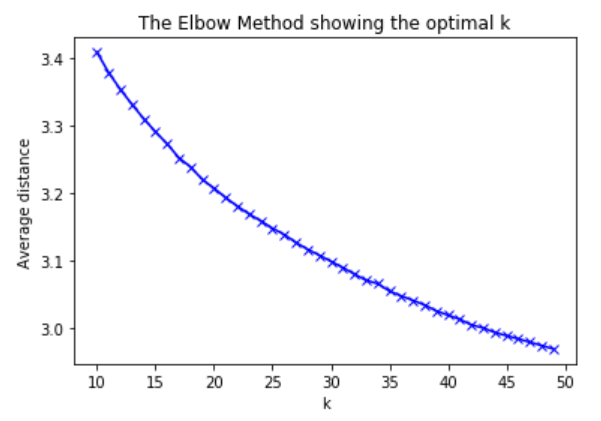

In [30]:
from IPython.display import display, Image
display(Image(filename=f_img_elbow_plot, width=400, height=400))

#### Select a value for *k* and train KMeans

In [31]:
k = 30
kmeans = KMeans(n_clusters=k, n_jobs=-1)
y = kmeans.fit_predict(X)

Serialize the created cluster on a file

In [32]:
pickle.dump(kmeans, open(f_kmeans, "w"))

Let's analyze the titles used

In [33]:
titles_cluster = pd.DataFrame(titles_train)
titles_cluster.head()

,title
1000002,"[0.3349695, 1.4830652, 0.6450566, 1.2887279, -..."
1000004,"[-0.48013508, -0.915525, -0.43725437, 0.795546..."
1000005,"[-0.41032225, -0.26731643, 1.5801424, 0.378979..."
1000019,"[0.006522637, 1.1512905, -0.47675228, -0.31809..."
1000024,"[-1.295901, 1.2341887, 0.7380845, 1.2273275, 0..."


Assign the associated cluster for each title

In [34]:
titles_cluster[lbl_cluster] = y
del titles_cluster[lbl_title]
titles_cluster.head()

,cluster
1000002,7
1000004,28
1000005,13
1000019,18
1000024,27


#### Analyze and interpret clustering results

Analyze the dimension of each cluster  

In [35]:
titles_cluster.groupby(lbl_cluster).size()

cluster
0     11254
1     11768
2     16942
3     12415
4      6358
5     10377
6      6954
7     17697
8      7882
9     19305
10    16663
11    11099
12    15145
13    13591
14    14042
15     4809
16    15754
17    17042
18    13774
19    10890
20    19315
21    16750
22    14817
23    15243
24    16534
25    15748
26    11968
27    10355
28    13629
29    19404
dtype: int64

In [36]:
titles_cluster.groupby(lbl_cluster).size().describe()

count       30.000000
mean     13584.133333
std       3880.485881
min       4809.000000
25%      11137.750000
50%      13908.000000
75%      16630.750000
max      19404.000000
dtype: float64

Seems to be a decently balanced clustering with this value of *k*

Assign the cluster label to the original dataframe and see the first 5 row

In [37]:
df_sample_dblp[lbl_cluster] = y
df_sample_dblp[[lbl_title, lbl_cluster]].head()

,title,cluster
1000002,Energy Efficiency and Reliability in Wireless ...,7
1000004,Clinical Text Prediction with Numerically Grou...,28
1000005,Using CamiTK for rapid prototyping of interact...,13
1000019,Random Words in a (Weighted) Regular Language:...,18
1000024,Beamforming Optimization for Full-Duplex Wirel...,27


Now print the first five title in each cluster.

Some relevant examples:
- Cluster 0: Robotics papers
- Cluster 3: Video and Speech Recognition papers 
- Cluster 4: Machine Learning papers
- Cluster 6: Cryptography papers
- Cluster 15: German papers
- Cluster 17: Cooperative Game Theory papers
- Cluster 22: Parallel Computing papers

In [38]:
for cluster, df_group in df_sample_dblp.groupby(lbl_cluster):
    print 'Cluster %d:' %cluster
    for _, title in df_group[lbl_title].head().iteritems():
        print '\t%s' %title
    print ''

Cluster 0:
	Robot Vision Architecture for Autonomous Clothes Manipulation.
	On-line Joint Limit Avoidance for Torque Controlled Robots by Joint Space Parametrization.
	Optimal Exploration of Terrains with Obstacles
	WiFiPos: An In/Out-Door Positioning Tool.
	Gyroscopically Stabilized Robot: Balance and Tracking

Cluster 1:
	Do Hard SAT-Related Reasoning Tasks Become Easier in the Krom Fragment?
	Comparison of polynomial-oriented computer algebra systems.
	Contextual Inference in Computational Semantics
	Record-Replay Debugging for Concurrent SCOOP Programs
	[tiger2/]- Serialising the ISO SynAF Syntactic Object Model

Cluster 2:
	A Business Maturity Model of Software Product Line Engineering.
	A Decision-Making Support System Based on Know-How
	Multi-Dimensional Customization Modelling Based On Metagraph For Saas Multi-Tenant Applications.
	Formal Visual Modeling of Real-Time Systems in e-Motions: Two Case Studies
	Research workshop on algebraic representations in computer-aided design 

In [39]:
kmeans.cluster_centers_.shape

(30L, 200L)

#### Automated naming of clusters: take the top 3 words per cluster

Rename the cluster ids with the concatenation of the first 3 words in the vocabulary that are closest to the cluster centroids.

In [40]:
# Map cluster ids to names
cluster_names = {}
for i in range(k):
    cluster_names[i] = '_'.join([word for word, score in model.wv.most_similar([kmeans.cluster_centers_[i]], topn=3)])
cluster_names = pd.Series(cluster_names)
cluster_names.name = lbl_cluster
cluster_names

0                  robot_robotic_endeffectors
1      specification_declarative_abstractions
2          software_componentbased_enterprise
3     recognition_classification_segmentation
4               learning_learner_metalearning
5               control_closedloop_controller
6            secure_encryption_authentication
7                   network_multihop_wireless
8                budapest_conference_workshop
9               analysis_methodology_modeling
10             whitening_prewhitening_subband
11                     data_metadata_database
12             linear_skewsymmetric_quadratic
13       interactive_interaction_mixedreality
14             heuristic_algorithm_algorithms
15                             werden_zu_eine
16            educational_elearning_education
17        social_organizations_organizational
18              antichains_graphs_multigraphs
19            circuit_lcvco_switchedcapacitor
20         microsphere_transmural_peristalsis
21                     llamada_res

Save cluster id -> name mapping to file for later usage.

In [41]:
f_cluster_id_name = path + 'cluster_id_name.csv'
cluster_names.to_csv(f_cluster_id_name, sep=',', header=True)

Apply the mapped cluster name to the original dataset.
Then print the first 5 rows

In [42]:
df_sample_dblp[lbl_cluster] = df_sample_dblp[lbl_cluster].apply(lambda x: cluster_names[x])
df_sample_dblp.head()

,authors,booktitle,ee,journal,paper_id,papertype,title,url,year,cluster
1000002,"[Jamshid Abouei, J. David Brown, Konstantinos ...",None,http://arxiv.org/abs/1101.0906,CoRR,journals/corr/abs-1101-0906,article,Energy Efficiency and Reliability in Wireless ...,db/journals/corr/corr1101.html#abs-1101-0906,2011.0,network_multihop_wireless
1000004,"[Georgios P. Spithourakis, Steffen E. Petersen...",None,http://arxiv.org/abs/1610.06370,CoRR,journals/corr/SpithourakisPR16,article,Clinical Text Prediction with Numerically Grou...,db/journals/corr/corr1610.html#SpithourakisPR16,2016.0,semantic_textual_document
1000005,"[Emmanuel Promayon, Céline Fouard, Mathieu Bai...",None,http://arxiv.org/abs/1310.5497,CoRR,journals/corr/PromayonFBDFHLPSSSVCT13,article,Using CamiTK for rapid prototyping of interact...,db/journals/corr/corr1310.html#PromayonFBDFHLP...,2013.0,interactive_interaction_mixedreality
1000019,"[Cewei Cui, Zhe Dang]",None,http://arxiv.org/abs/1711.08963,CoRR,journals/corr/abs-1711-08963,article,Random Words in a (Weighted) Regular Language:...,db/journals/corr/corr1711.html#abs-1711-08963,2017.0,antichains_graphs_multigraphs
1000024,"[Batu K. Chalise, Himal A. Suraweera, Gan Zhen...",None,http://arxiv.org/abs/1705.04014,CoRR,journals/corr/ChaliseSZK17,article,Beamforming Optimization for Full-Duplex Wirel...,db/journals/corr/corr1705.html#ChaliseSZK17,2017.0,channel_multiantenna_mimo


#### Show WordClouds for each cluster

Wordcloud for cluster image_texture_images:


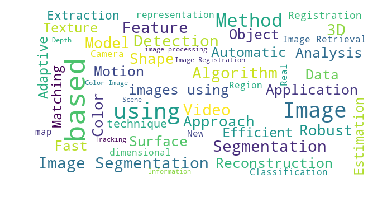


Wordcloud for cluster heuristic_algorithm_algorithms:


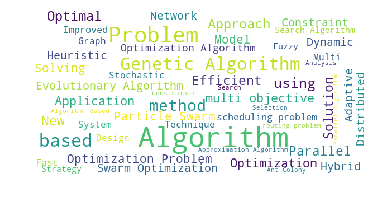


Wordcloud for cluster specification_declarative_abstractions:


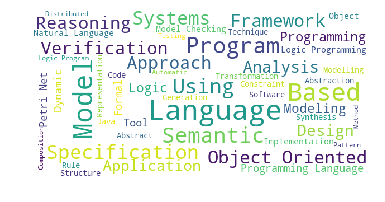


Wordcloud for cluster social_organizations_organizational:


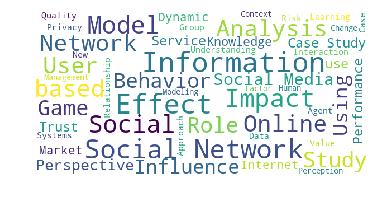


Wordcloud for cluster infinitary_finitary_equational:


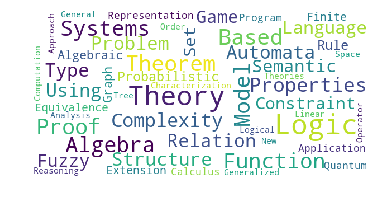


Wordcloud for cluster interactive_interaction_mixedreality:


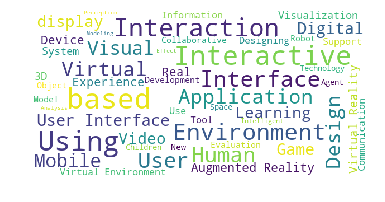


Wordcloud for cluster secure_encryption_authentication:


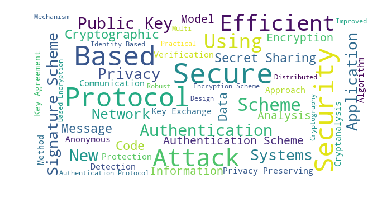


Wordcloud for cluster educational_elearning_education:


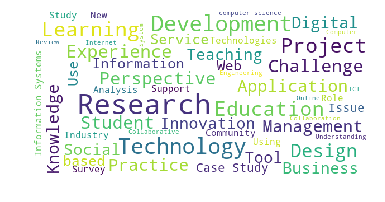


Wordcloud for cluster circuit_lcvco_switchedcapacitor:


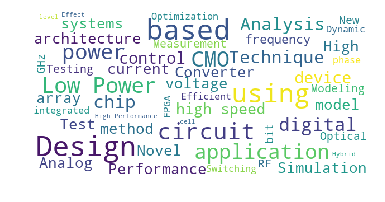


Wordcloud for cluster learning_learner_metalearning:


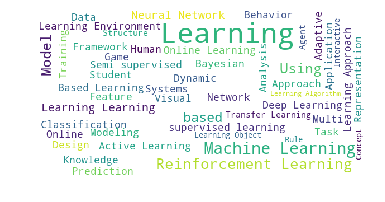


Wordcloud for cluster analysis_methodology_modeling:


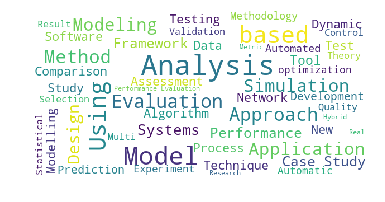


Wordcloud for cluster whitening_prewhitening_subband:


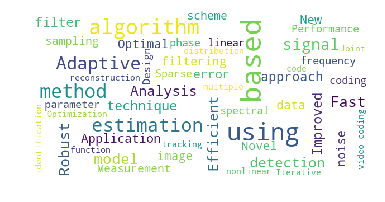


Wordcloud for cluster recognition_classification_segmentation:


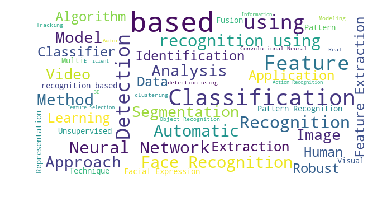


Wordcloud for cluster semantic_textual_document:


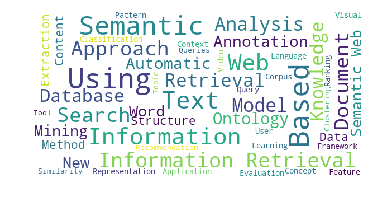


Wordcloud for cluster antichains_graphs_multigraphs:


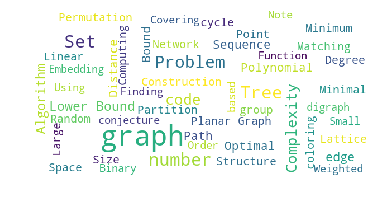


Wordcloud for cluster hardware_multiprocessor_multicore:


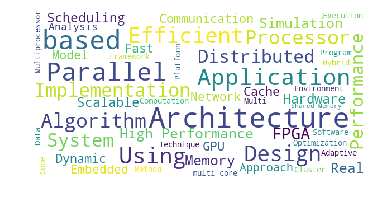


Wordcloud for cluster network_multihop_wireless:


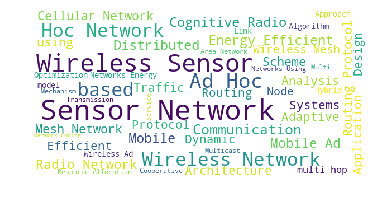


Wordcloud for cluster software_componentbased_enterprise:


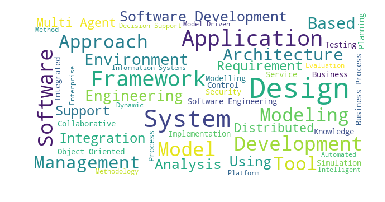


Wordcloud for cluster data_metadata_database:


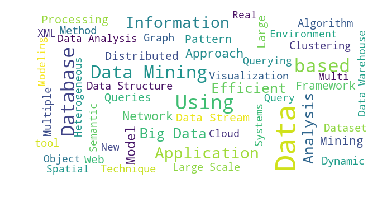


Wordcloud for cluster clustering_classifier_classification:


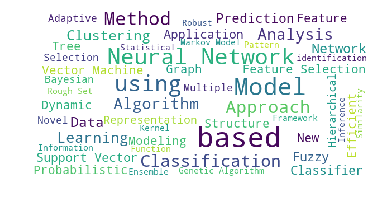


Wordcloud for cluster microsphere_transmural_peristalsis:


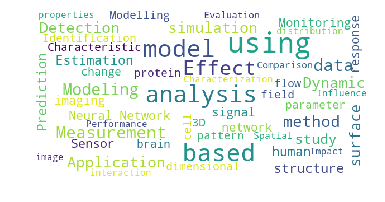


Wordcloud for cluster llamada_restent_keinen:


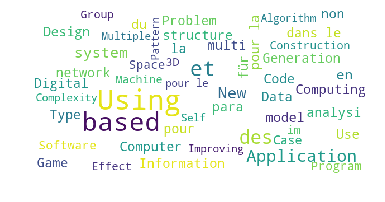


Wordcloud for cluster scheduling_qos_routing:


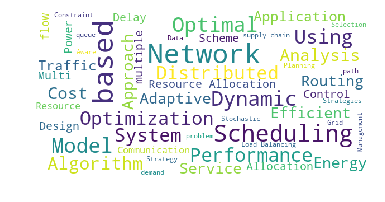


Wordcloud for cluster budapest_conference_workshop:


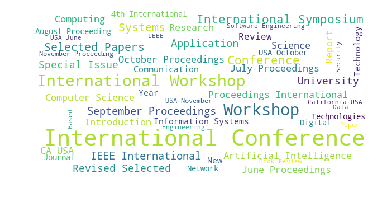


Wordcloud for cluster werden_zu_eine:


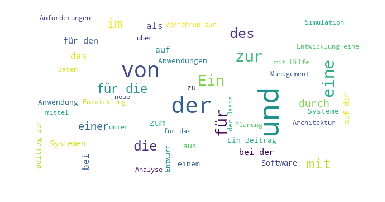


Wordcloud for cluster channel_multiantenna_mimo:


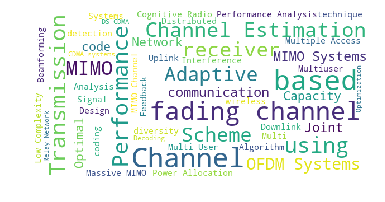


Wordcloud for cluster linear_skewsymmetric_quadratic:


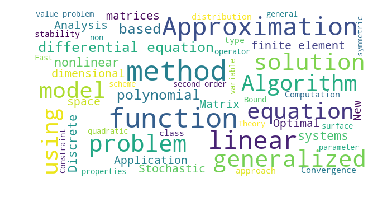


Wordcloud for cluster services_infrastructure_middleware:


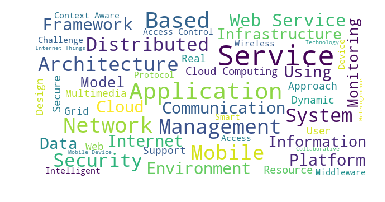


Wordcloud for cluster control_closedloop_controller:


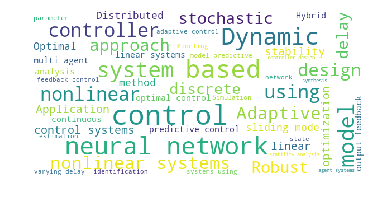


Wordcloud for cluster robot_robotic_endeffectors:


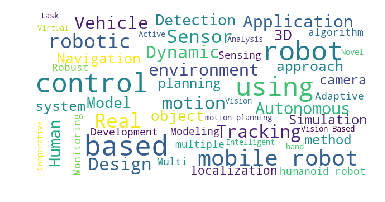

In [43]:
from wordcloud import WordCloud

for cluster, df_cluster_indices in df_sample_dblp.groupby(lbl_cluster).groups.iteritems():
    df_cluster = df_sample_dblp.loc[df_cluster_indices]
    print 'Wordcloud for cluster %s:' %cluster
    text = df_cluster[lbl_title].str.cat(sep=' ')

    wordcloud = WordCloud(background_color='white', stopwords=stopw,
                          width=600, height=300, max_font_size=50, max_words=50).generate(text)
    wordcloud.recolor()
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()   
    plt.close()
    print ''

### Serialize the result

In [44]:
df_paper_clusters = df_sample_dblp[[lbl_paper_id, lbl_cluster]]
df_paper_clusters.to_csv(f_paper_clusters, sep=',', index=False)